# -- SECTION 1: PROCESS WORKTHROUGH --

### Determine process for a single player (pass rusher) for a single play.

# I. Load Libraries

In [119]:
# Standard base libraries
import pandas as pd
import numpy as np

# Used for calculating pursuit angle (metric/metric component)
from scipy import spatial

# For plotting player movement
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Misc
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# II. Load Data (as DataFrames)

In [120]:
# Play outcome data
scout = pd.read_csv('data/pffScoutingData.csv')

# Player tracking data
w1 = pd.read_csv('data/week1.csv')

# III. Clean Data

### 1. Isolate and clean pass rusher scouting data

In [121]:
# Isolate pass rushers
scout_pass_rush = scout[scout.pff_role == 'Pass Rush']

# Strip unnecessary columns, rename and retype
scout_pass_rush = scout_pass_rush[['gameId',
                                 'playId',
                                 'nflId',
                                 'pff_positionLinedUp',
                                 'pff_hit',
                                 'pff_hurry',
                                 'pff_sack',]].rename(columns = {'gameId':'game',
                                                                'playId':'play',
                                                                'pff_positionLinedUp':'position',
                                                                'pff_hit':'hit',
                                                                'pff_hurry':'hurry',
                                                                'pff_sack':'sack'}).astype({'hit':int,
                                                                                            'hurry':int,
                                                                                            'sack':int})

# Create a catch-all column for pressure
scout_pass_rush['pressure'] = scout_pass_rush.hit + scout_pass_rush.hurry + scout_pass_rush.sack

scout_pass_rush.head(2)

,game,play,nflId,position,hit,hurry,sack,pressure
6,2021090900,97,41263,LEO,0,1,0,1
8,2021090900,97,42403,ROLB,0,1,0,1


### 2. Load and clean weekly data

In [122]:
# Choose week
week = w1

In [123]:
week = week.drop(columns = ['time','playDirection','team','jerseyNumber']).rename(columns = {'gameId':'game',
                                                                       'playId':'play',
                                                                       'frameId':'frame',}).fillna(0).astype({'nflId':int})
                                                                                                               
week.head(2)

,game,play,nflId,frame,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511,1,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511,2,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None


# IV. Create Object with games and plays in each game

##### Should use a dictionary for this, as found below:

In [124]:
# game_plays = {}
# for game in week.game.unique():
#     print(game)
#     plays = []
#     for play in week[week.game == game].play.unique():
#         plays.append(play)
#     game_plays[game] = plays

In [125]:
# Then pull individual plays using this
# game = 2021091208

# for plays in game_plays[game]:
#     print(plays)

*Can also use a multilevel index for this.  TBD.*

#### For now will create a list of (game, play) tuples:

In [126]:
week_game_plays = []
for game in week.game.unique():
    for play in week[week.game == game].play.unique():
        week_game_plays.append((game,play))

# V. For a select play in a select game, create football and player dataframes

### 1. Create a dataframe with scouting data for pass rushers on selected play only and then create list of players

##### For testing - create random variables to test game and play

In [127]:
# 1175 passing plays in week 1 across 16 games
game_index = np.random.randint(0,1174)

game = week_game_plays[game_index][0]
play = week_game_plays[game_index][1]

game, play

(2021091212, 2703)

In [128]:
# Determine pass rushers on this play
scout_play = scout_pass_rush[scout_pass_rush.game == game][scout_pass_rush.play == play]
scout_play

,game,play,nflId,position,hit,hurry,sack,pressure
21869,2021091212,2703,40031,LOLB,0,0,1,1
21871,2021091212,2703,42349,LEO,0,1,0,1
21874,2021091212,2703,43332,DRT,0,0,0,0
21885,2021091212,2703,47800,DLT,0,0,0,0


Select a random pass rusher from this play:

In [129]:
pass_rushers = list(scout_play.nflId)
pass_rusher = np.random.choice(pass_rushers)
pass_rusher

47800

### 2. Create dataframe with 0.1s frame data for selected play only

In [130]:
# Creates dataframe for single play from single game
play_frames = week[week.game == game][week.play == play]

### 3. Pull out football frames, get initial x (line of scrimmage) and then truncate from ball snap to end event
- Note: 'End event' is when the pass rusher stops pursuing the qb/ball in the backfield as the ball has been passes, the qb has taken off on a run, or tehre is a sack or other event that ends their role as a pass rusher.

In [131]:
# Creates football frame data for play
football_frames = play_frames[play_frames.nflId ==0].set_index('frame',drop = True)

In [132]:
# Get the x value for the line of scrimmage (for use with play graphing)
line_of_scrimmage = football_frames.x.iloc[0]
line_of_scrimmage

83.47

In [133]:
trigger = 0

for i, event in enumerate(football_frames.event):
    # If the event is a ball_snap, stores the snap index and triggers the function to start checking events
    if event == 'ball_snap':
        snap_index = i + 1
        trigger = 1
        continue

    if trigger == 1:
        # The following events are not end events
        if event in ['None','autoevent_ballsnap','autoevent_passforward','play_action','first_contact','shift','man_in_motion','line_set']:
            continue
        # If the trigger is on and the event is an end event, return the index
        else:
            end_index = i + 1
    else:
        continue

In [134]:
snap_index, end_index

(7, 54)

In [135]:
# Use the frame index to remove unecessary frames from the play (pre-snap and post pass event)
football_frames = football_frames[(football_frames.index >= snap_index) & (football_frames.index <= end_index)]

In [136]:
#  Removing unecessary columns and renaming things
football_frames = football_frames.drop(columns = ['game',
                                      'play',
                                      'nflId',
                                      'o',
                                      'dir',
                                      'event']).rename(columns = {'x':'ball_x',
                                                                 'y':'ball_y',
                                                                 's':'ball_s',
                                                                 'a':'ball_a',
                                                                 'dis':'ball_dis'})

#### Merging the pass rusher with the football frames

In [137]:
pass_rusher_play = football_frames.merge(play_frames[play_frames.nflId == pass_rusher].set_index('frame',drop = True),
                                        on = 'frame', how = 'left').reset_index(drop = True)

Calculate distance at each point

In [138]:
# Simply use pythagorean formula to calculate distance at time of frame based on x and y coordinates
pass_rusher_play['ball_player_distance'] = ((pass_rusher_play.x - pass_rusher_play.ball_x)**2 +
                                (pass_rusher_play.y - pass_rusher_play.ball_y)**2)**.5

# Add the change in distance betweem the previous frame (initial frame will be dropped later)
# !-Not sure if this is necessary
#pass_rusher_play['change_distance'] = pass_rusher_play.ball_player_distance.diff()

In [139]:
pass_rusher_play['prev_distance'] = pass_rusher_play.ball_player_distance.shift(1)

In [140]:
# Shifting the x and y allows to compare past coordinate location to present, giving us a movement vector
pass_rusher_play['shift_x'] = pass_rusher_play.x.shift(1)

pass_rusher_play['shift_y'] = pass_rusher_play.y.shift(1)

In [141]:
# I am sure there is a way to calcualte directly in df using assign, but this calcualtes the angle between the player
# and the ball after they both move, and the direction the player actually moved in that interval.  A negative value
# means the player is moving in a direction away from the ball; a zero (0) value means they are moving perpendicular
# to it; for positive values, the closer to one the more direct the movement - a value of one means they move directly
# towards the ball in that interval.

# Need to initialize with a value to account for the shift
pursuit_angle_factor = [[0,0]]

for i in pass_rusher_play.index[1:]:
    pursuit_angle_factor.append(
        1 - spatial.distance.cosine(
            [round(pass_rusher_play.x.iloc[i]-pass_rusher_play.shift_x.iloc[i],3),
            round(pass_rusher_play.y.iloc[i]-pass_rusher_play.shift_y.iloc[i],3)],
            [round(pass_rusher_play.ball_x.iloc[i]-pass_rusher_play.shift_x.iloc[i],3),
            round(pass_rusher_play.ball_y.iloc[i]-pass_rusher_play.shift_y.iloc[i],3)]))

pass_rusher_play['pursuit_factor'] = pursuit_angle_factor

In [142]:
# Shifting the x and y for the ball as well to get it's movement vector
pass_rusher_play['shift_ball_x'] = pass_rusher_play.ball_x.shift(1)

pass_rusher_play['shift_ball_y'] = pass_rusher_play.ball_y.shift(1)

In [143]:
# Need to initialize with a value to account for the shift
escape_angle_factor = [[0,0]]

for i in pass_rusher_play.index[1:]:
    escape_angle_factor.append(
        1 - spatial.distance.cosine(
            [round(pass_rusher_play.ball_x.iloc[i]-pass_rusher_play.shift_ball_x.iloc[i],3),
            round(pass_rusher_play.ball_y.iloc[i]-pass_rusher_play.shift_ball_y.iloc[i],3)],
            [round(pass_rusher_play.x.iloc[i]-pass_rusher_play.shift_ball_x.iloc[i],3),
            round(pass_rusher_play.y.iloc[i]-pass_rusher_play.shift_ball_y.iloc[i],3)]))

pass_rusher_play['escape_factor'] = escape_angle_factor

In [144]:
pass_rusher_play['distance_proportion'] = pass_rusher_play['ball_player_distance']/pass_rusher_play['prev_distance']

In [145]:
pass_rusher_play = pass_rusher_play[1:-1]

In [146]:
pass_rusher_play['pursuit'] = pass_rusher_play.dis * pass_rusher_play.pursuit_factor
pass_rusher_play['escape'] = pass_rusher_play.ball_dis * -pass_rusher_play.escape_factor

In [147]:
pass_rusher_play['true_pursuit'] = pass_rusher_play.pursuit + pass_rusher_play.escape

In [148]:
pass_rusher_play['metric'] = (pass_rusher_play.ball_player_distance + pass_rusher_play.true_pursuit)/(pass_rusher_play.ball_player_distance)

#test_a
test_b = pass_rusher_play.metric

In [149]:
pass_rusher_play

,ball_x,ball_y,ball_s,ball_a,ball_dis,game,play,nflId,x,y,s,a,dis,o,dir,event,ball_player_distance,prev_distance,shift_x,shift_y,pursuit_factor,shift_ball_x,shift_ball_y,escape_factor,distance_proportion,pursuit,escape,true_pursuit,metric
1,83.96,23.63,0.57,0.67,0.06,2021091212,2703,47800,85.70,22.07,0.75,2.16,0.07,309.27,309.36,None,2.336921,2.445915,85.75,22.03,0.998506,83.90,23.63,0.755689,0.955438,0.069895,-0.045341,0.024554,1.010507
2,83.99,23.63,0.54,0.63,0.03,2021091212,2703,47800,85.62,22.13,1.10,2.32,0.10,282.46,308.52,None,2.215152,2.336921,85.70,22.07,0.99539,83.96,23.63,0.741959,0.947894,0.099539,-0.022259,0.07728,1.034887
3,82.50,23.91,0.09,0.95,1.52,2021091212,2703,47800,85.51,22.21,1.46,2.21,0.13,290.03,306.72,None,3.456892,2.215152,85.62,22.13,0.993919,83.99,23.63,-0.844243,1.560566,0.129209,1.28325,1.412459,1.408592
4,82.43,23.92,0.31,2.49,0.07,2021091212,2703,47800,85.37,22.31,1.80,1.96,0.17,288.07,305.69,None,3.351970,3.456892,85.51,22.21,0.993574,82.50,23.91,-0.933523,0.969648,0.168908,0.065347,0.234254,1.069886
5,82.35,23.93,0.72,3.74,0.07,2021091212,2703,47800,85.20,22.41,2.06,1.47,0.20,293.08,302.82,None,3.230000,3.351970,85.37,22.31,0.999225,82.43,23.92,-0.930603,0.963613,0.199845,0.065142,0.264987,1.082039
6,82.25,23.94,1.37,5.70,0.11,2021091212,2703,47800,85.00,22.53,2.30,1.10,0.23,287.91,300.60,None,3.090405,3.230000,85.20,22.41,0.998081,82.35,23.93,-0.926286,0.956782,0.229559,0.101891,0.33145,1.107251
7,82.07,23.95,2.09,6.22,0.18,2021091212,2703,47800,84.79,22.67,2.50,0.74,0.25,281.95,301.52,None,3.006127,3.090405,85.00,22.53,0.990669,82.25,23.94,-0.917857,0.972729,0.247667,0.165214,0.412881,1.137347
8,81.82,23.97,2.81,6.06,0.25,2021091212,2703,47800,84.57,22.81,2.63,0.50,0.27,278.21,301.85,None,2.984644,3.006127,84.79,22.67,0.988144,82.07,23.95,-0.940056,0.992854,0.266799,0.235014,0.501813,1.168132
9,81.51,23.98,3.36,5.12,0.31,2021091212,2703,47800,84.33,22.96,2.72,0.03,0.28,276.11,301.84,None,2.998800,2.984644,84.57,22.81,0.981357,81.82,23.97,-0.939263,1.004743,0.27478,0.291172,0.565952,1.188726
10,81.16,24.00,3.72,3.77,0.35,2021091212,2703,47800,84.09,23.11,2.75,0.37,0.28,276.11,302.20,None,3.062189,2.998800,84.33,22.96,0.970959,81.51,23.98,-0.964262,1.021138,0.271869,0.337492,0.60936,1.198995


Clean up play:

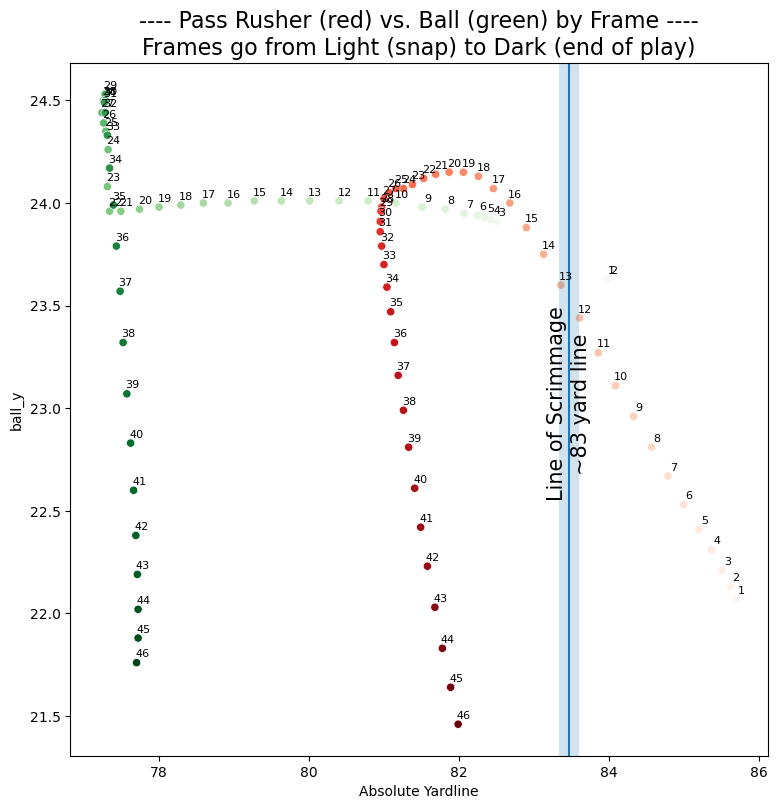

In [150]:
# ToDo - Make each point for the player a vector facing the ball?
pass_rusher_analysis_frames = pass_rusher_play.copy()

plt.figure(figsize = [9,9])
plt.title('---- Pass Rusher (red) vs. Ball (green) by Frame ----\nFrames go from Light (snap) to Dark (end of play)', fontsize = 16)
plt.xlabel('Absolute Yardline')
plt.ylabel('')

# Create and graphe the datapoints
sns.scatterplot(x = pass_rusher_analysis_frames.ball_x, y = pass_rusher_analysis_frames.ball_y, hue = pass_rusher_analysis_frames.index, palette = 'Greens', legend = False)
sns.scatterplot(x = pass_rusher_analysis_frames.x, y = pass_rusher_analysis_frames.y, hue = pass_rusher_analysis_frames.index, palette = 'Reds', legend = False)

# Create the frame lables for the player
for mark in zip(pass_rusher_analysis_frames.index,pass_rusher_analysis_frames.x,pass_rusher_analysis_frames.y):
    plt.annotate(mark[0],
                (mark[1], mark[2]),
                textcoords = 'offset points',
                xytext = (4,4),
                ha = 'center',
                fontsize = 8)
# Create the frame labels for the football
for mark in zip(pass_rusher_analysis_frames.index,pass_rusher_analysis_frames.ball_x,pass_rusher_analysis_frames.ball_y):
    plt.annotate(mark[0],
                (mark[1], mark[2]),
                textcoords = 'offset points',
                xytext = (4,4),
                ha = 'center',
                fontsize = 8)

# At figsize = [12,12], the line width of the line of scrimmage = 19.2; change in proportion to this
plt.axvline(x = line_of_scrimmage,
            lw = 14.4,
            alpha = 0.2)
plt.axvline(x = line_of_scrimmage)
plt.text(line_of_scrimmage, (pass_rusher_analysis_frames.ball_y.mean() + pass_rusher_analysis_frames.y.mean())/2, 
        f'Line of Scrimmage\n~{int(line_of_scrimmage)} yard line',
        fontsize = 15, rotation = 90,
        ha = 'center',
        va = 'top')

plt.show()

In [ ]:
p.head()

Dropping the first and last frames, along with unecessary columns

Create a testing dataframe

In [29]:
def metric_generator(b1,b0,p1,p0):
    '''
    Input the coordinates of the ball and player and frame t (0) and t+1 (1)
    '''
    # Break the coodiantes into components
    bx_1 = b1[0]
    by_1 = b1[1]

    bx_0 = b0[0]
    by_0 = b0[1]


    px_1 = p1[0]
    py_1 = p1[1]

    px_0 = p0[0]
    py_0 = p0[1]
    
    # Determine the distance moved by the player and the ball
    player_dis_moved = ((px_1 - px_0)**2 + (py_1 - py_0)**2)**.5
    ball_dis_moved = ((bx_1 - bx_0)**2 + (by_1 - by_0)**2)**.5

    # Determine the distance between the player and that ball between frames
    dis_0 = ((bx_0 - px_0)**2 + (by_0 - py_0)**2)**.5
    dis_1 = ((bx_1 - px_1)**2 + (by_1 - py_1)**2)**.5

    # Deterine the pursuit factor - the component of the player's movement vector that moved towards new ball location
    pursuit_factor = spatial.distance.cosine(
                        [round(bx_1 - px_0,3),
                        round(by_1 - py_0,3)],
                        [round(px_1 - px_0,3),
                        round(py_1- px_0,3)])
    
    # Determine the escape factor - the component of the ball's movement vector going away from the player
    escape_factor = spatial.distance.cosine(
                        [round(bx_0 - bx_1,3),
                        round(by_0 - by_1,3)],
                        [round(px_1 - bx_1,3),
                        round(py_1-by_1,3)])
    
    # Calculate the change in distance between player and ball between frames
    change_in_dis = dis_1 - dis_0
    
    # Calculate the proportion of distance
    distance_proportion = dis_1 / dis_0
    
    # Multiply the pursuit factor by the distance traveled to get magnitude traveled towards ball
    player_pursuit_vector_magnitude = pursuit_factor * player_dis_moved
    
    # Multiply the escape factor by the ball distance traveled
    ball_escape_vector_magnitude = -escape_factor * ball_dis_moved
    
    # Distance between ending ball location and player (for potential use)
    player_start_to_ball_end = ((bx_1 - px_0)**2 + (by_1 - py_0)**2)**.5
    
    # independent pursuit
    absolute_pursuit = player_pursuit_vector_magnitude - ball_escape_vector_magnitude
    
    # Metric - compares change due to player movement compared to change overall
    # !- Need to dterminei if it is an add or subtract
    metric = ((dis_0 - absolute_pursuit)/dis_0)/distance_proportion

#     if graph == True:
#         c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])

#         lc = collections.LineCollection([[(bx_1,by_1),(bx_0,by_0)],[(px_1,py_1),(px_0,py_0)],[(bx_1,by_1),(px_0,py_0)]], colors = c, linewidths = 2)

#         fig, ax = pl.subplots()
#         ax.add_collection(lc)
#         ax.autoscale()
    
    return {'start_dis':dis_0,
            'end_dis':dis_1,
            'change_in_dis':change_in_dis,
            'dis_end_to_start_ratio':distance_proportion,
            'player_dis_moved':player_dis_moved,
            'pursuit_factor':pursuit_factor,
            'player_mag':player_pursuit_vector_magnitude,
            'ball_dis_moved': ball_dis_moved,
            'escape_factor':escape_factor,
            'ball_mag':ball_escape_vector_magnitude,
            'absolute_pursuit':absolute_pursuit,
            'metric':metric}

In [32]:
p = p[1:-1]
p = p.drop(columns = ['ball_s','ball_a','game','play','s','a','o','dir','event'])

In [34]:
p

,ball_x,ball_y,ball_dis,nflId,x,y,dis,ball_player_distance,prev_distance,shift_x,shift_y,pursuit_factor,shift_ball_x,shift_ball_y,escape_factor
1,34.88,23.76,0.00,38619,34.12,25.73,0.06,2.111516,2.176350,34.07,25.78,0.080519,34.88,23.76,0
2,36.22,23.66,1.35,38619,34.19,25.67,0.09,2.856746,2.111516,34.12,25.73,0.00242,34.88,23.76,1.408816
3,37.00,23.66,0.78,38619,34.28,25.60,0.12,3.340958,2.856746,34.19,25.67,0.000805,36.22,23.66,1.707107
4,37.78,23.66,0.78,38619,34.39,25.52,0.14,3.866743,3.340958,34.28,25.60,0.007514,37.00,23.66,1.814365
5,38.49,23.66,0.70,38619,34.53,25.44,0.15,4.341659,3.866743,34.39,25.52,0.004345,37.78,23.66,1.877069
6,39.15,23.66,0.67,38619,34.69,25.37,0.18,4.776578,4.341659,34.53,25.44,0.000997,38.49,23.66,1.911922
7,39.73,23.63,0.57,38619,34.87,25.30,0.19,5.138920,4.776578,34.69,25.37,0.00074,39.15,23.66,1.951031
8,40.25,23.57,0.53,38619,35.07,25.24,0.21,5.442545,5.138920,34.87,25.30,0.000193,39.73,23.63,1.97638
9,40.74,23.49,0.49,38619,35.28,25.20,0.21,5.721512,5.442545,35.07,25.24,0.00617,40.25,23.57,1.988
10,41.05,23.47,0.31,38619,35.49,25.16,0.21,5.811170,5.721512,35.28,25.20,0.005308,40.74,23.49,1.970489


In [35]:
output_list = []

for i in p.index -1 :
    b1 = (p.iloc[i].ball_x,p.iloc[i].ball_y)
    b0 = (p.iloc[i].shift_ball_x,p.iloc[i].shift_ball_y)
    p1 = (p.iloc[i].x,p.iloc[i].y)
    p0 = (p.iloc[i].shift_x,p.iloc[i].shift_y)

    output_list.append(metric_generator(b1,b0,p1,p0))

kobe = pd.DataFrame(output_list)

In [36]:
kobe

,start_dis,end_dis,change_in_dis,dis_end_to_start_ratio,player_dis_moved,pursuit_factor,player_mag,ball_dis_moved,escape_factor,ball_mag,absolute_pursuit,metric
0,2.176350,2.111516,-0.064834,0.970210,0.070711,0.069626,0.004923,0.000000,0.000000,0.000000,0.004923,1.028373
1,2.111516,2.856746,0.745230,1.352936,0.092195,0.292123,0.026932,1.343726,0.239010,-0.321164,0.348097,0.617282
2,2.856746,3.340958,0.484212,1.169498,0.114018,0.409725,0.046716,0.780000,0.185862,-0.144973,0.191688,0.797693
3,3.340958,3.866743,0.525785,1.157375,0.136015,0.504262,0.068587,0.780000,0.123293,-0.096169,0.164756,0.821415
4,3.866743,4.341659,0.474916,1.122821,0.161245,0.572674,0.092341,0.710000,0.087906,-0.062413,0.154754,0.854970
5,4.341659,4.776578,0.434920,1.100174,0.174642,0.624238,0.109018,0.660000,0.066277,-0.043743,0.152761,0.876966
6,4.776578,5.138920,0.362342,1.075858,0.193132,0.655606,0.126619,0.580775,0.038752,-0.022506,0.149125,0.900472
7,5.138920,5.442545,0.303625,1.059083,0.208806,0.674175,0.140772,0.523450,0.019341,-0.010124,0.150896,0.916487
8,5.442545,5.721512,0.278967,1.051257,0.213776,0.684826,0.146399,0.496488,0.010019,-0.004974,0.151373,0.924786
9,5.721512,5.811170,0.089658,1.015670,0.213776,0.692994,0.148145,0.310644,0.026483,-0.008227,0.156372,0.957663


Graphing the play:

Lastly, the metric is the mean metric during the play:

In [ ]:
kobe.metric.mean()

## Lastly, figure out a way to store the results for each player, for each play and then port to a dataframe that has players as rows, weekly metric score in columns, and total at the end

---
# -- SECTION 2: FUNCTION DEVELOPMENT AND TESTING --

# 1. Load Python function library

In [ ]:
import nfl_functions

# Needed to select random player
import numpy as np

# 2. Acquire and return cleaning data

In [ ]:
scout_csv = 'data/pffScoutingData.csv'
week_csv = 'data/week1.csv'


pass_rushers = nfl_functions.prep_scout_data(scout_csv)
week = nfl_functions.prep_weekly_data(week_csv)

Create a random play to analyze:

In [ ]:
game, play = nfl_functions.random_play(week)

In [ ]:
game = 2021091200
play = 2631
pass_rusher = 46416

# 3. Build Analysis Frame(s)

In [ ]:
# game and play are from above

pass_rush_list = nfl_functions.get_play_pass_rushers(pass_rushers, game, play)

Get the play and frames

In [ ]:
play_frames = nfl_functions.get_play_frames(week, game, play)

In [ ]:
line_of_scrimmage, football_frames = nfl_functions.play_fb_frames(play_frames)

In [ ]:
pass_rusher = np.random.choice(pass_rush_list)

In [ ]:
pass_rusher_analysis_frames = nfl_functions.create_pass_rusher_analysis_frames(football_frames, play_frames, pass_rusher)

In [ ]:
pass_rusher_analysis_frames

In [ ]:
pursuit_angle, test_factor_a = nfl_functions.metrics(pass_rusher_analysis_frames, return_graph = True, line_of_scrimmage = line_of_scrimmage)
pursuit_angle, test_factor_a